# MNIST using RNN

## 시작하기

* 사용할 라이브러리를 import 합니다. 
* 본 예제는 tensorflow를 사용합니다.
* 데이터셋은 tensorflow에서 제공하는 mnist 데이터셋을 사용합니다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

import os
import time

tf.reset_default_graph()
%matplotlib inline

## 데이터셋 불러오기

* 사용할 데이터셋을 불러온다. 
* images: 0부터 9까지 필기체로 작성된 흑백영상 (1채널). 
* label: one_hot 형태로 설정한다. 

- 0 = [1 0 0 0 0 0 0 0 0 0]
- 1 = [0 1 0 0 0 0 0 0 0 0]

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print("Number of train data is %d" % (mnist.train.num_examples))
print("Number of test data is %d" % (mnist.test.num_examples))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of train data is 55000
Number of test data is 10000


## 데이터셋 확인하기

학습 데이터의 이미지와 레이블을 확인한다.

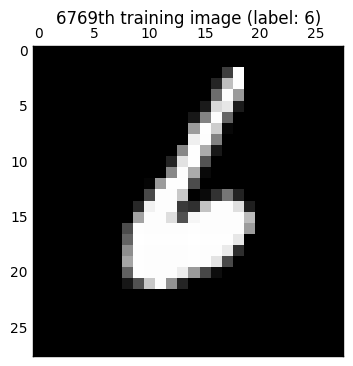

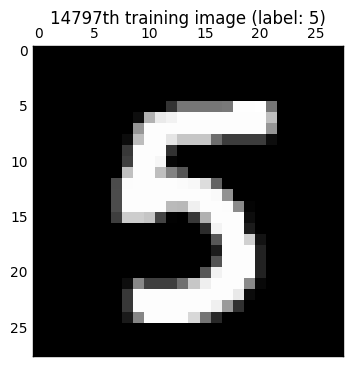

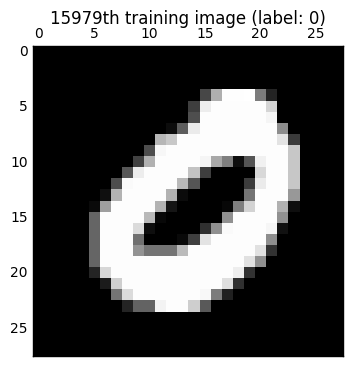

In [3]:
nsample = 3
rand_idx = np.random.randint(mnist.train.images.shape[0], size=nsample)

for i in rand_idx:
    curr_img = np.reshape(mnist.train.images[i, :], (28,28))
    curr_lbl = np.argmax(mnist.train.labels[i, :])
    plt.matshow(curr_img, cmap=plt.get_cmap('gray'))
    plt.title(""+str(i)+"th training image "
              + "(label: " + str(curr_lbl) + ")")
    plt.show()

## 이미지 분류를 위한 RNN 구성

28x28 이미지를 RNN 입력을 위해 아래와 같이 구성한다.

* input_vec_size: 하나의 이미지 (28x28) 중 한 행씩 RNN의 입력으로 사용한다.
* time_step_size: 하나의 이미지 (28x28)를 모두 입력하려면 28개의 행이 필요하다. 따라서 time_step은 28.
* lstm_size: rnn_cell에 포함된 hidden unit의 수

In [4]:
# configuration
#                        O * W + b -> 10 labels for each image, O[? 28], W[28 10], B[10]
#                       ^ (O: output 28 vec from 28 vec input)
#                       |
#      +-+  +-+       +--+
#      |1|->|2|-> ... |28| time_step_size = 28
#      +-+  +-+       +--+
#       ^    ^    ...  ^
#       |    |         |
# img1:[28] [28]  ... [28]
# img2:[28] [28]  ... [28]
# img3:[28] [28]  ... [28]
# ...
# img128 or img256 (batch_size or test_size 256)
#      each input size = input_vec_size=lstm_size=28

In [5]:
input_vec_size = lstm_size = 28
time_step_size = 28

batch_size = 128
test_size = 256

## RNN 모델 정의

In [9]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, W, B, lstm_size):
    # X, input shape: (batch_size, time_step_size, input_vec_size)
    XT = tf.transpose(X, [1, 0, 2])  # permute time_step_size and batch_size
    # XT shape: (time_step_size, batch_size, input_vec_size)
    XR = tf.reshape(XT, [-1, lstm_size]) # each row has input for each lstm cell (lstm_size=input_vec_size)
    # XR shape: (time_step_size * batch_size, input_vec_size)
    X_split = tf.split(0, time_step_size, XR) # split them to time_step_size (28 arrays)
    # Each array shape: (batch_size, input_vec_size)

    # Make lstm with lstm_size (each input vector size)
    lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=True)

    # Get lstm cell output, time_step_size (28) arrays with lstm_size output: (batch_size, lstm_size)
    outputs, _states = tf.nn.rnn(lstm, X_split, dtype=tf.float32)

    # Linear activation
    # Get the last output
    return tf.matmul(outputs[-1], W) + B, lstm.state_size # State size to initialize the stat

## 데이터 변환

* training과 test 데이터를 1d에서 2d형태로 reshape한다.
* 입력과 출력에 해당하는 placeholder 선언

In [10]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28)
teX = teX.reshape(-1, 28, 28)

X = tf.placeholder("float", [None, 28, 28])
Y = tf.placeholder("float", [None, 10])

## 모델 선언

* Hidden unit과 output unit크기만큼 모델 생성
* 모델 생성

In [11]:
# get lstm_size and output 10 labels
W = init_weights([lstm_size, 10])
B = init_weights([10])

py_x, state_size = model(X, W, B, lstm_size)

## loss 함수 선언 및 최적화

In [12]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

## 세션 생성 및 학습 정확도 측정

In [13]:
# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(100):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})

        test_indices = np.arange(len(teX))  # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y: teY[test_indices]})))

(0, 0.68359375)
(1, 0.859375)
(2, 0.90234375)
(3, 0.9296875)
(4, 0.95703125)
(5, 0.90234375)
(6, 0.9453125)
(7, 0.94140625)
(8, 0.94921875)
(9, 0.98046875)
(10, 0.96875)
(11, 0.96875)
(12, 0.984375)
(13, 0.96484375)
(14, 0.98828125)
(15, 0.98046875)
(16, 0.953125)
(17, 0.98046875)
(18, 0.98828125)
(19, 0.96875)
(20, 0.96875)
(21, 0.95703125)
(22, 0.96875)
(23, 0.96484375)
(24, 0.98828125)
(25, 0.98046875)
(26, 0.98046875)
(27, 0.97265625)
(28, 0.96875)
(29, 0.98828125)
(30, 0.9765625)
(31, 0.97265625)
(32, 0.9609375)
(33, 0.9609375)
(34, 0.96484375)
(35, 0.98046875)
(36, 0.98046875)
(37, 0.984375)
(38, 0.98046875)
(39, 0.9765625)
(40, 0.98046875)
(41, 0.9765625)
(42, 0.9921875)
(43, 0.97265625)
(44, 0.96875)
(45, 0.9765625)
(46, 0.984375)
(47, 0.98828125)
(48, 0.95703125)
(49, 0.9921875)
(50, 0.96875)
(51, 0.98046875)
(52, 0.984375)
(53, 0.9765625)
(54, 0.96875)
(55, 0.97265625)
(56, 0.953125)
(57, 0.97265625)
(58, 0.984375)
(59, 0.984375)
(60, 0.9765625)
(61, 0.97265625)
(62, 0.976562